# ***Book Crossing Recommendation System Dataset*** 

## **Import Library**

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [160]:
import sklearn 
from sklearn.neighbors import NearestNeighbors

## **Data Collecting**

In [161]:
path = "/content/drive/My Drive/Dataset/BookCrossing_Dataset"

In [162]:
book_data = pd.read_csv(path + "/Books.csv", sep=';', header=0)

In [163]:
book_data.head()

,ISBN,Title,Author,Year,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company


In [164]:
rating_data = pd.read_csv(path + "/Ratings.csv", sep=";", header=0)
rating_data.head()

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [165]:
user_data = pd.read_csv(path + "/Users.csv", sep=";", header=0)
user_data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,User-ID,Age
0,1,NaN
1,2,18
2,3,NaN
3,4,17
4,5,NaN


## **Data Preprocessing**

### Book Data and Rating Data

In [166]:
book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISBN       271379 non-null  object
 1   Title      271379 non-null  object
 2   Author     271378 non-null  object
 3   Year       271379 non-null  int64 
 4   Publisher  271377 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


In [167]:
book_data.isnull().sum()

ISBN         0
Title        0
Author       1
Year         0
Publisher    2
dtype: int64

In [168]:
book_data.loc[book_data.Publisher.isnull(),:]

,ISBN,Title,Author,Year,Publisher
128896,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129043,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [169]:
book_data["Publisher"] = book_data["Publisher"].fillna("Other")

In [170]:
book_data.loc[book_data.Author.isnull(),:]

,ISBN,Title,Author,Year,Publisher
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [171]:
book_data["Author"] = book_data["Author"].fillna("Other")

In [172]:
book_data.describe(include=np.object).T

,count,unique,top,freq
ISBN,271379,271378,0486404242,2
Title,271379,242154,Selected Poems,27
Author,271379,102031,Agatha Christie,632
Publisher,271379,16911,Harlequin,7536


#### Merge Book Df and Rating Df with User Df


In [173]:
group_user = rating_data.groupby("User-ID")
group_book = rating_data.groupby("ISBN")

mean_user_rating = group_user["Rating"].mean()
count_user_rating = group_user["Rating"].count()

mean_book_rating = group_book["Rating"].mean()
count_book_rating = group_book["Rating"].count()

mean_user_rating.name = "Average_Rating"
count_user_rating.name = "Count_Rating"
mean_book_rating.name = "Average_Rating"
count_book_rating.name = "Count_Rating"


In [174]:
group_user.head()

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149763,276704,0395404258,0
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [175]:
group_book.head()

,User-ID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149770,276704,0679752714,0
1149773,276704,0806917695,5
1149774,276704,0876044011,0
1149775,276704,1563526298,9


#### Join with original df


In [176]:
user_data = user_data.merge(count_user_rating, on="User-ID")
user_data = user_data.merge(mean_user_rating, on="User-ID")

book_data = book_data.merge(count_book_rating, on="ISBN")
book_data = book_data.merge(mean_book_rating, on="ISBN")

In [177]:
user_data.isnull().sum()

User-ID               0
Age               40518
Count_Rating          0
Average_Rating        0
dtype: int64

In [178]:
book_data.isnull().sum()

ISBN              0
Title             0
Author            0
Year              0
Publisher         0
Count_Rating      0
Average_Rating    0
dtype: int64

In [179]:
user_data["Count_Rating"] = user_data["Count_Rating"].astype("int8")
book_data["Count_Rating"] = book_data["Count_Rating"].astype("int8")

### User Data

In [180]:
user_data.isnull().sum()

User-ID               0
Age               40518
Count_Rating          0
Average_Rating        0
dtype: int64

In [181]:
user_data["Age"].count()
#Around 18000 value is nonNaN for Age.

58535

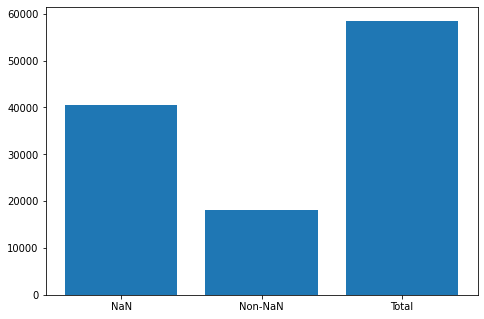

In [182]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x_tick = ["NaN","Non-NaN", "Total"]
value = [40518,(58535-40518),58535]
ax.bar(x_tick, value)
plt.show()

In [183]:
user_data["Age"] = user_data["Age"].fillna(0)

### Rating Dataset

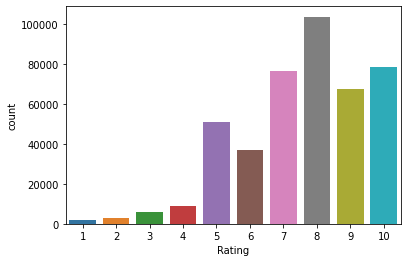

In [184]:
sns.countplot(data=rating_data[rating_data.Rating != 0], x="Rating")
plt.show()

## Basic Recommendation System

In [185]:
rating_new = rating_data[rating_data.ISBN.isin(book_data.ISBN)]
rating_new = rating_new[rating_new["User-ID"].isin(user_data["User-ID"])]

In [186]:
rating_without_0 = rating_new[rating_new.Rating != 0]
rating_with_0 = rating_new[rating_new.Rating == 0]

In [187]:
rating_count = pd.DataFrame(rating_without_0.groupby(["ISBN"])["Rating"].sum())
firstTop = rating_count.sort_values("Rating", ascending=False).head()

print("Recommend Book:")
firstTop.merge(book_data, left_index = True, right_on = "ISBN")

Recommend Book:


,Rating,ISBN,Title,Author,Year,Publisher,Count_Rating,Average_Rating
408,5423,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",15,4.468726
748,3908,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,115,4.652322
522,2925,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,-45,4.334716
2139,2639,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,59,4.900175
356,2482,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,103,4.219512


## Recommend Similar Book - Content Base Filtering 

In [188]:
rating_data["Rating"] = rating_data["Rating"].astype("int8")

In [189]:
matrix_df = pd.merge(book_data.loc[book_data["Count_Rating"] > 20, "ISBN"], rating_data, how="left", left_on="ISBN", right_on="ISBN").drop_duplicates()

In [190]:
matrix_df.head()

,ISBN,User-ID,Rating
0,0399135782,8,0
1,0399135782,11676,9
2,0399135782,29526,9
3,0399135782,36836,0
4,0399135782,46398,9


In [191]:
matrix_df_pivot = matrix_df.pivot_table(index="ISBN", columns="User-ID", values="Rating").fillna(0).astype("int8")

In [192]:
import scipy
from scipy.sparse import csr_matrix

In [193]:
matrix_csr = csr_matrix(matrix_df_pivot.values)

In [194]:
model = NearestNeighbors(metric="cosine", n_neighbors=11, n_jobs=-1)
model.fit(matrix_csr)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                 radius=1.0)

In [195]:
distance, indices = model.kneighbors(matrix_csr)

In [196]:
#Using a random book to check
print("Random book index: ", np.where(matrix_df_pivot.index == "0399135782")[0][0])

Random book index:  2148


In [197]:
select_index = 2148

In [198]:
print("You used to like {} then we recommend you:".format(book_data.loc[book_data["ISBN"] == matrix_df_pivot.index[indices[select_index][0]], "Title"].values[0]))
print()
for i in range(1, 11):
  print("{} with distance {}".format(book_data.loc[book_data['ISBN'] == matrix_df_pivot.index[indices[select_index][i]], 'Title'].values[0], distance[select_index][i]))

You used to like The Kitchen God's Wife then we recommend you:

Gai-Jin: A Novel of Japan with distance 0.7773521222729239
The Greatest Generation Speaks : Letters and Reflections with distance 0.7927500619424043
INCA GOLD with distance 0.8091558577296116
The Inheritor with distance 0.8143441756734172
Yuletide Brides (2 Novels in 1) with distance 0.8279239497453084
The Bellmaker (Redwall, Book 7) with distance 0.8287077908935335
The Observatory : A Novel with distance 0.8319151143745407
How to Make an American Quilt with distance 0.8345857405068295
Joy Luck Club with distance 0.834768484998744
The Unlikely Spy with distance 0.8359819519594547


## Recommend User Favourite Book - Collaborative Filtering

In [199]:
harry_potter_isbns = book_data.loc[book_data["Title"].str.contains("Harry Potter") & book_data["Author"].str.contains("Rowling"), "ISBN"].values
harry_potter_ratings = rating_data.loc[rating_data["ISBN"].isin(harry_potter_isbns)]

In [200]:
user_groupby = harry_potter_ratings.groupby("User-ID")
average_user_rating = user_groupby["Rating"].mean()
number_of_ratings_by_user = user_groupby["Rating"].count()

In [215]:
average_user_rating.name = "HP_avg_ratings"
number_of_ratings_by_user.name = "HP_N_ratings"

In [208]:
users = user_data.join(number_of_ratings_by_user, on="User-ID")
users = user_data.join(average_user_rating, on="User-ID")

In [209]:
users["Count_Rating"] = users["Count_Rating"].fillna(0)
users["Count_Rating"] = users["Count_Rating"].astype("int64")

In [226]:
users.loc[users["HP_avg_rating"] == 7]

,User-ID,Age,Count_Rating,Average_Rating,HP_avg_rating
1708,4802,28,17,2.470588,7.0
2585,7072,11,8,6.500000,7.0
4338,12112,40,26,2.423077,7.0
5373,14958,39,100,6.890000,7.0
6427,17667,33,85,4.329412,7.0
7487,20501,30,10,6.200000,7.0
8342,22688,0,1,7.000000,7.0
9572,25919,0,42,5.476190,7.0
10983,29482,29,1,7.000000,7.0
11234,30153,13,1,7.000000,7.0


In [217]:
knn = NearestNeighbors(metric="cosine", n_neighbors=20, n_jobs=-1)
knn.fit(matrix_csr.T)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

In [218]:
distance_knn, indices_knn = knn.kneighbors(matrix_csr.T)

In [221]:
matrix_df_pivot.columns.get_loc(175003)

28785

In [222]:
indices_knn[28785]

array([28785, 17007, 41708, 19175,  1082,  6058, 45787,  3394, 32093,
       14660,  4883,  5223, 13850, 31294, 14170, 19055,  8585, 39092,
       23788, 39521])

In [223]:
matrix_df_pivot.columns[17007]

103541

In [224]:
users.loc[users["User-ID"] == 103541]

,User-ID,Age,Count_Rating,Average_Rating,HP_avg_rating
39275,103541,24,111,6.738739,8.5


In [230]:
def recommend_favourite_book_of_similar_user(userID, indices, ratings_matrix, users_table, books_table, ratings_table, N_recommendations=1, distances=None):
    selected_index = ratings_matrix.columns.get_loc(userID)
    already_read_book_isbns = list(ratings_table.loc[ratings_table["User-ID"] == userID, "ISBN"].values)
    not_read_books = ratings_table.loc[~ratings_table["ISBN"].isin(already_read_book_isbns)]
    books_to_recommend = list()
    for i in range(1,10):
        similar_user_index = indices[selected_index][i]
        similar_user_ID = ratings_matrix.columns[similar_user_index]
        possible_to_recommend = not_read_books.loc[not_read_books["User-ID"] == similar_user_ID]
        possible_to_recommend = possible_to_recommend.sort_values(by="Rating", ascending=False)
        for a, row in possible_to_recommend.iterrows():
            books_to_recommend.append(books_table.loc[book_data["ISBN"] == row["ISBN"], "Title"].values[0])
            if len(books_to_recommend) > N_recommendations-1:
                break
        if len(books_to_recommend) > N_recommendations-1:
            break
    print(f"Based on users who like similar books as you, you may like:")
    print()
    for book_name in books_to_recommend:
        print(book_name)

In [231]:
recommend_favourite_book_of_similar_user(12112, indices_knn, matrix_df_pivot, users, book_data, rating_data, N_recommendations=3, distances=distance_knn)

Based on users who like similar books as you, you may like:

The Runaway Jury
Lies My Teacher Told Me : Everything Your American History Textbook Got Wrong
Zorba the Greek
